Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [ ]:
!python --version

If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

### *General information on running our notebook:*
 
- In addition to the libraries from the Google colab version of notebook we use the following libraries for data handling, efficient computing and evaluating algorithm performance:
   - tqdm (to show progress bars in loops)- https://pypi.org/project/tqdm/#installation
   - wget (to download the datasets locally) - https://anaconda.org/anaconda/wget
   - time (to get program execution times)
   - pandas (for data handling) - https://pandas.pydata.org/docs/getting_started/install.html
   - scipy (for efficient computations) - https://scipy.org/install/
   
- We use *Class* based approach and techniques to run our expirements. This makes coding tractable and easy to debug.
- Additional information is provided as comments at required places.

In [2]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=52f0780d173a5de5b5ad7892d01db89fa5fae83a88cd47770dfed0f1b5cf8708
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
#from google.colab import drive #uncomment the import if running in colab
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np
import wget  #comment this import if running in colab
from tqdm import tqdm
import time
import pandas as pd
import scipy

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [4]:
'''
NOTE:
    1. If the notebook is run locally this cell is required to be run only once- 
    (generally the first time the notebook is run) because the datasets are downloaded locally. 
    2. Uncomment the !wget and comment the wget.download if running in colab. 
'''
# download sentiment lexicon
#!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
wget.download('https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon','sent_lexicon')
# download review data
#!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
wget.download('https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json','reviews.json')

'reviews.json'

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [5]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.

with open("reviews.json", mode="r", encoding="utf-8") as f:
    reviews = json.load(f)

print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s): 
    print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
    print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents 
    print_sentence_with_pos(r["content"][0]) 
    if i == 4: 
        break
    
c = Counter()
for review in reviews: 
    for sentence in review["content"]: 
        for token, pos_tag in sentence:
            c[token.lower()] += 1

print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20): 
    print("%10s : %8d" % (token, count))

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

# Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [17]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    line_cnt = 0 
    for line in f:
        print(line.strip()) 
        line_cnt += 1
        if line_cnt > 4:
            break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [7]:
# YOUR CODE HERE

'''We first format the Lexicon as a dictionary which makes data retrival efficient and fast'''

lexicon = {}
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    for line in f:
        key = line.split('word1=',maxsplit=1)[1].split(maxsplit=1)[0]
        senti = line.split('priorpolarity=',maxsplit=1)[1].rstrip('\n')
        senti_mag = line.split('type=',maxsplit=1)[1].split()[0]
        lexicon[key] = [senti, senti_mag]

'''
Now we create Lexicon based classifier. To use the classifier:
    1. Instantiate the class Lex_Approach with arguments:
        1. document: reviews
        2. sentiment lexicon: the lexicon
        3. multiplier: assigns weight based on magnitude informattion. Default value is 1
        4. use_better_threshold: a boolean value indicating whether to use threshod based on document length. Defalut in False
    2. Then call the method classify(), which returns the accuracy of the classifier.

Eg: suppose we want a classifier with multiplier 2 (strong sentiments are weighted 2x more than weak).Then do
lex_classifier = Lex_Approach(reviews, lexicon, 2, False)
accuracy = lex_classifier.classify()

Helper functions: 
    1. plotter(): Helps to visualize how accuracy varies with multiplier and using a better threshold       
'''
class Lex_Approach:

    def __init__(self, document, sentiment_lexicon, multiplier=1, use_better_threshold=False):
        self.document = document
        self.lexicon = sentiment_lexicon
        self.multiplier = multiplier
        self.threshold = 8
        self.use_better_threshold = use_better_threshold
        self.results, self.score_list, self.doc_length = [], [], 0
        
        
    def compute_threshold(self):
        review_list = []
        scale_factor = 1
        for review in self.document:
            review_length = 0
            senti_counter = Counter()
            for sentence in review['content']:
                self.doc_length += len(sentence)
                review_length += len(sentence)
                for token, pos_tag in sentence:
                    if self.lexicon.get(token.lower()) == None:
                        pass
                    else:
                        if self.lexicon[token.lower()][1] == 'strongsubj':
                            senti_counter[self.lexicon[token.lower()][0]] += self.multiplier  
                        else:
                            senti_counter[self.lexicon[token.lower()][0]] += 1 
                    
            self.score_list.append(senti_counter['positive']-senti_counter['negative'])
            
            if self.use_better_threshold:
                scale_factor = review_length #when using the better threshold scale factor is review length
                
            review_list.append([senti_counter, scale_factor])  
                
        if self.use_better_threshold:
            self.threshold = np.sum(self.score_list)/self.doc_length
        else:
            if self.multiplier==1:   
                pass
            else:
                self.threshold = np.mean(self.score_list) 
            
        return review_list
    
    
    def classify(self):
        review_list = self.compute_threshold()
        
        for idx, i in enumerate(review_list):
            if (i[0]['positive'] - (i[1]*self.threshold)) > i[0]['negative']:  
                classify = 'POS'
            else:
                classify = 'NEG'

            if classify==self.document[idx]['sentiment']:
                self.results.append(1)
            else:
                self.results.append(0)
                
        return np.mean(self.results)  
    
    @staticmethod
    def plotter(doc, lex, better_thres,max_multiplier=5):
        
        assert better_thres in [True,False], 'Can only take boolean values: True or False'
        if better_thres: title_string = ' using a better threshold'
        else: title_string = ''
            
        multiplier_list = np.linspace(0,max_multiplier)
        accuracy_list = []
        for i in tqdm(multiplier_list):
            lex_classifier = Lex_Approach(document=doc, sentiment_lexicon=lex, multiplier=i,use_better_threshold=better_thres)
            accuracy = lex_classifier.classify()
            accuracy_list.append(accuracy)
            
        max_idx = np.argmax(accuracy_list)
        x_max, y_max = multiplier_list[max_idx],accuracy_list[max_idx]
        fig, ax = plt.subplots(dpi=150)
        ax.set_title('Lexicon based classifier accuracy'+ title_string)
        ax.plot(multiplier_list, accuracy_list,label='accuracy')
        ax.set_xlim(0,max_multiplier)
        ax.set_ylim(0.5,y_max+0.1)

        ax.annotate('max accuracy',xy=(x_max,y_max),xytext=(x_max+0.5, y_max-0.05),arrowprops=dict(arrowstyle='-|>'))
        x_ticks = np.append(ax.get_xticks(), float('{:.2f}'.format(x_max)))
        y_ticks = np.append(ax.get_yticks(), float('{:.3f}'.format(y_max)))

        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        x_labels = ax.get_xticklabels()
        y_labels = ax.get_yticklabels()

        x_labels[-1].set_fontsize(6)
        x_labels[-1].set_weight("bold")
        x_labels[-1].set_rotation(90)

        y_labels[-1].set_fontsize(6)
        y_labels[-1].set_weight("bold")
        y_labels[-1].set_rotation(45)

        ax.hlines(y_max,0,x_max,'r',lw=0.5,ls='--')
        ax.vlines(x_max,0,y_max,'r',lw=0.5,ls='--')
        ax.set_ylabel('accuracy')
        ax.set_xlabel('multiplier')
        ax.tick_params(axis='both', which='major', labelsize=7)
        plt.grid(alpha=0.5)
        plt.tight_layout()
        plt.legend()
        plt.show()

In [8]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification.
lex_classifier = Lex_Approach(document=reviews, sentiment_lexicon=lexicon, multiplier=1, use_better_threshold=False)
token_accuracy = lex_classifier.classify()
token_results = lex_classifier.results

print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.68


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


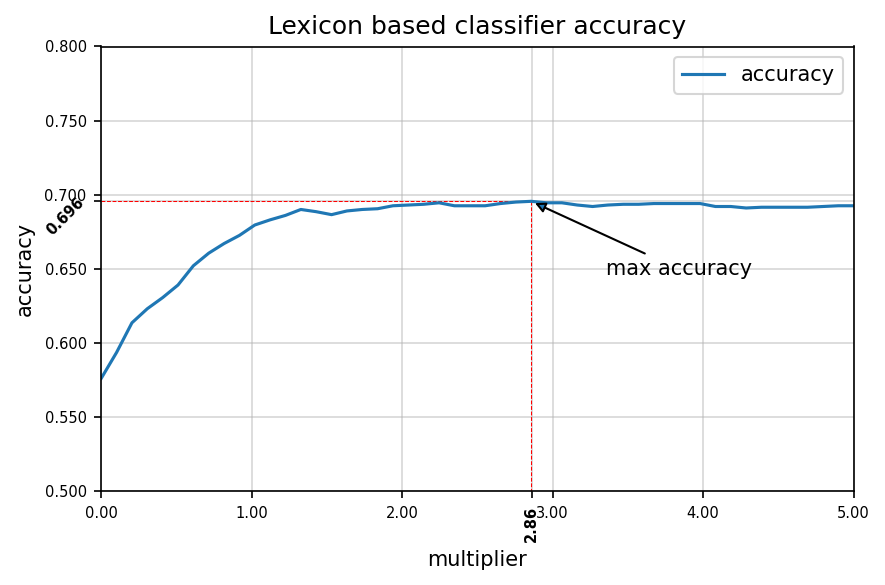

In [9]:
# YOUR CODE HERE

#lets 1st visualise how accuracy varies with multiplier
Lex_Approach.plotter(doc=reviews, lex=lexicon, better_thres=False, max_multiplier=5)

In [10]:
#now use the multiplier that gives maximum accuracy
lex_classifier_with_mag = Lex_Approach(document=reviews, sentiment_lexicon=lexicon, multiplier=2.86, use_better_threshold=False)
magnitude_accuracy = lex_classifier_with_mag.classify()
magnitude_results = lex_classifier_with_mag.results # a list of binary indicators

print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.70


#### (Q.1.4) Make a barplot of the two results (0.5pt)

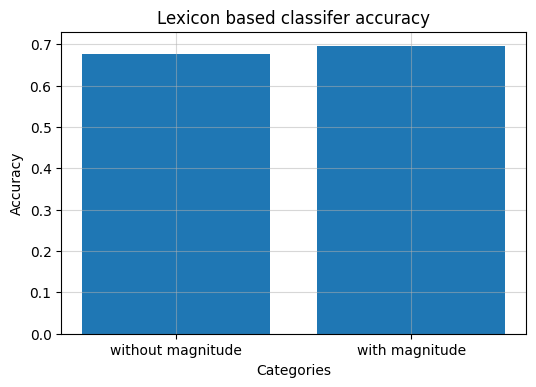

In [11]:
# YOUR CODE HERE
plt.figure(dpi=100)
height = [token_accuracy, magnitude_accuracy]
bars = ('without magnitude', 'with magnitude')
x_pos = np.arange(len(bars))
 
plt.bar(x_pos, height)
 
# Add title and axis names
plt.title('Lexicon based classifer accuracy')
plt.xlabel('Categories')
plt.ylabel('Accuracy')
 
plt.xticks(x_pos, bars)
plt.grid(alpha=0.5)
plt.show()

#### (Q1.3) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

**Answer**  

The thresholds we used above is based on an averaged absolute difference in positive and negative words. However this won't be fair for short documents which are likely to have less positive words than longer documents. In other words, we can't be sure if more number of positive words is actually due to document length or sentiment class.  For instance, if we assume that positive words occur at 1.05 times as often as negative words, i.e $5\%$ more, then very long documents will easily pass the threshold, even if their overall sentiment is negative.

We can avoid this by computing the average score for each word over the whole document and requiring that each review has an individual threshold which we compute as the average score times the length of each review, given as:
$$\begin{align}
\text{threshold for review}_i &= \text{average score for all words}\times\text{length of}\text{ review}_i\\
                   &= \frac{\sum_{i=1}^{N}\text{score of }\text{review}_i}{\sum_{i=1}^{N}\text{length of }\text{review}_i}\times\text{length of}\text{ review}_i,\quad \forall \,i \in \{1,2\dots N\}
\end{align}$$

100%|██████████| 50/50 [00:38<00:00,  1.28it/s]


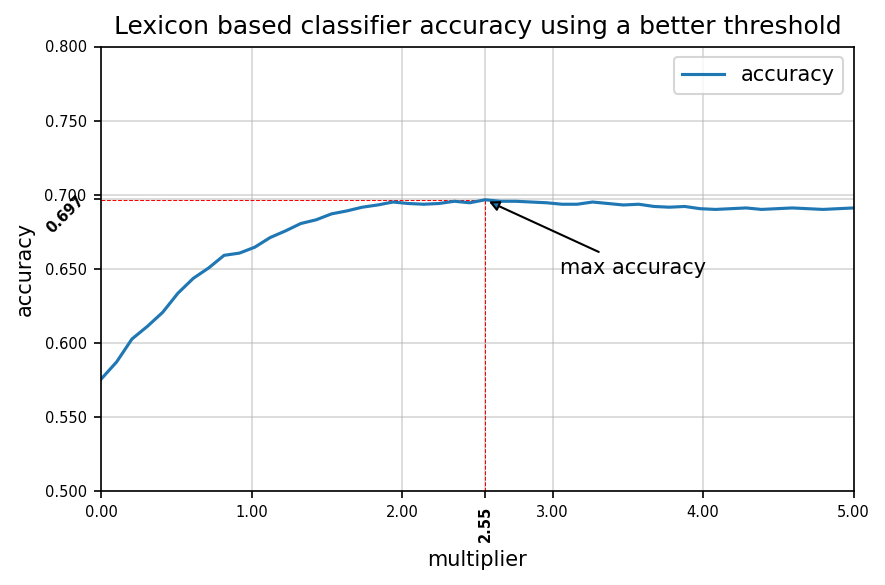

In [12]:
# YOUR CODE HERE
#lets see how accuracy changes by using the better threshold 
Lex_Approach.plotter(doc=reviews, lex=lexicon, better_thres=True, max_multiplier=5)

In [ ]:
#using the multiplier that maximizes accuracy
lex_better_thresh = Lex_Approach(document=reviews, sentiment_lexicon=lexicon, multiplier=2.55, use_better_threshold=True)
better_accuracy = lex_better_thresh.classify()
print("Accuracy: %0.2f" % better_accuracy)

Accuracy: 0.70


# Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**.  What would be the problem instead with skipping words only for one class in case 2? 

**Answer**  

Skipping a word means assigning it a probability 1, i.e $P(f_i|c) = 1$. If we skip a word for the class for which it did not occur in training but include it for the other one, this would increase the likelihood of the class for which the word did not occur. This is would clearly bias our classification results.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [13]:
# YOUR CODE HERE
'''
We create two Classes:
    1. BAG_OF_WORDS: this builds our bag of words with different stratergies. See the init function to see the parameters
                     this class accepts. This class will be used both by Naive Bayes and SVM classifier.
    2. Naive_Bayes: this is our Naive Bayes classifier with different stratergies. See the init function for parameters.
    
Note: Since we use inheritance, the parameters for BAG_OF_WORDS can be used across both Naive_Bayes and SVM classes.      
'''

class BAG_OF_WORDS:
    def __init__(self, stemmer=None, use_ngrams=False):
        assert use_ngrams in [True,False], 'use_ngrams can only take True or False'
        self.use_ngrams = use_ngrams
        self.stemmer = stemmer
        self.SVM_flag = False
        self.train_df = None
        self.Ng = 1
        if self.use_ngrams: 
            self.Ng = int(input("Enter max number of grams you want to use as features: ")) 
            assert (type(self.Ng)==int and self.Ng>=2), 'Number of grams should be an integer >= 2!'
        
    def create_bow(self, document, is_train=True, use_pos=False, discard_cc=False):
        BOW = {'POS':Counter(), 'NEG':Counter()}
        stemmed_dict = {}
        sentiment_encoder = {'POS':1,'NEG':0} #used for encoding when using SVM
        
        OPEN_CLASS = ['JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS', 'RB', 'RBR','RBS','MD','VB','VBD','VBG'
                      'VBN','VBP','VBZ'] 
        if self.SVM_flag:
            feature_list = [] 
            label_list = []
            
        for review in document:
            temp_counter = Counter()  #use temporary counter for SVM
            senti = review['sentiment']
            if self.SVM_flag:
                for sentence in review['content']:
                    for token, pos_tag in sentence:
                        if discard_cc:
                            if pos_tag not in OPEN_CLASS:
                                continue #skip closed class words 
                        if use_pos: word = token.lower()+ '/'+ pos_tag.lower()
                        else: word = token.lower()
                        temp_counter[word] += 1
                        
                feature_list.append(dict(temp_counter))
                label_list.append(sentiment_encoder[senti]) #encode the categorical labels 'NEG' and 'POS'
                
            else:
                for sentence in review['content']:
                    if self.Ng!=1:     
                        grams = [item for sublist in [list(ngrams([w.lower() for w, _ in sentence], n = k))
                                                      for k in range(2,self.Ng+1)] for item in sublist]
                        for g in grams:
                            BOW[senti][g] += 1

                    for token,pos_tag in sentence:
                        word = token.lower()
                        if self.stemmer!=None:
                            if word not in stemmed_dict:
                                stem = self.stemmer.stem(word)
                                stemmed_dict[word] = stem    
                            word = stemmed_dict[word]                  
                    
                        BOW[senti][word] += 1
        
        if self.SVM_flag:
            if is_train:
                self.train_df = pd.DataFrame(feature_list)
                self.train_df.fillna(0,inplace=True) #replace all NaNs with 0
                features_mat = scipy.sparse.csr_matrix(self.train_df.values) #convert to a sparse matrix for efficient computations
                return features_mat, np.array(label_list) #returns features and labels
            else:
                assert len(self.train_df!=None), 'First create bag of words with a Train corpus!'
                index_dict = {key:idx for idx,key in enumerate(self.train_df.columns)} #contains all the word in train corpus
                rows, cols = len(label_list), len(self.train_df.columns)
                feature_array = np.zeros((rows, cols))
                for idx, word_dict in enumerate(feature_list):
                    for word in word_dict: #filter unseen words
                        if word in index_dict:
                            feature_array[idx, index_dict[word]] = word_dict[word]
                        
                features_mat = scipy.sparse.csr_matrix(feature_array)
                return features_mat, np.array(label_list)
    
        else:
            return BOW, len(BOW['POS']+BOW['NEG'])    #returns the BoW and the size of vocabulary
                

class Naive_Bayes(BAG_OF_WORDS):
    def __init__(self, train, test, stemmer=None, use_ngrams=False, smoothing=0):
        super().__init__(stemmer,use_ngrams)
        assert (smoothing>=0), 'Smoothing takes positive values only!'
        self.train = train
        self.test = test
        self.smoothing = smoothing
        self.results = []
        self.V = 0
        self.confusion_mat = np.zeros((2,2))
                    
    def classify(self):
        
        #create a bag of words
        BOW, self.V = self.create_bow(self.train)
        #calculate the prior probablities
        N_doc = len(self.train)
        N_pos = sum([1 for x in self.train if x['sentiment']=='POS'])
        prior_pos = N_pos/N_doc
        prior_neg = 1- prior_pos
        total_pos = sum(BOW['POS'].values()) 
        total_neg = sum(BOW['NEG'].values()) 
        
        for review in self.test:
            pos_log_likelihood, neg_log_likelihood = np.log10(prior_pos), np.log10(prior_neg)
            if self.stemmer!=None:
                feature_list = [self.stemmer.stem(token.lower()) for sentence in review['content'] 
                                for token, pos_tag in sentence]
            else:
                feature_list = [token.lower() for sentence in review['content'] for token, pos_tag in sentence]
                
            if self.use_ngrams:
                for sentence in review['content']:
                    test_grams = [item for sublist in [list(ngrams([w.lower() for w, _ in sentence], n = k))
                                                       for k in range(2,self.Ng+1)] for item in sublist]
                    feature_list += test_grams
                    
            for feat in feature_list:
                if self.smoothing==0:
                    if BOW['POS'].get(feat) != None and BOW['NEG'].get(feat) != None:
                        pos_log_likelihood += np.log10(BOW['POS'][feat]/total_pos)
                        neg_log_likelihood += np.log10(BOW['NEG'][feat]/total_neg)
                    else: continue 
                        
                else:
                    if BOW['POS'].get(feat) == None and BOW['NEG'].get(feat) == None: continue 
                    else:
                        pos_log_likelihood += np.log10((BOW['POS'][feat] + self.smoothing)/(total_pos + (self.smoothing*self.V)))
                        neg_log_likelihood += np.log10((BOW['NEG'][feat] + self.smoothing)/(total_neg+ (self.smoothing*self.V)))                     
           
            if pos_log_likelihood > neg_log_likelihood: classify = 'POS'
            else: classify = 'NEG'
                
            if classify == review['sentiment']: 
                self.results.append(1)
                if classify=='POS': self.confusion_mat[0][0] += 1
                else: self.confusion_mat[1][1] += 1    
            else: 
                self.results.append(0) 
                if classify == 'POS': self.confusion_mat[0][1] += 1
                else: self.confusion_mat[1][0] += 1
        
        return np.mean(self.results)
    
    @staticmethod
    def cross_validate(document, n_folds=10, kappa=0, stem_strat=None, use_svm=False, use_pos=False, 
                       discard_cc=False, use_ngrams=False):
        
        all_fold_indxs = [[n for n in range(len(document)) if n % n_folds==i] for i in range(n_folds)]
        folds = [[document[idx] for idx in singl_fold_idx] for singl_fold_idx in all_fold_indxs]
        accuracy_list = []
        if use_ngrams:
            N_g = int(input("\nEnter max number of grams you want to use as features: ")) 
            assert (type(N_g)==int and N_g>=2), 'Number of grams should be an integer >= 2!'

        for i in range(n_folds):
            test_set = folds[i]
            train_set = [rev for j in range(n_folds) if j != i for rev in folds[j]]
            if use_svm:
                svm_classifier = SVM(train_set, test_set,use_pos=use_pos, discard_cc=discard_cc)
                start_time = time.time()
                acc, _ = svm_classifier.classify()
                execution_time = time.time() -start_time 
            else: 
                nb_classifier = Naive_Bayes(train_set, test_set, smoothing=kappa, stemmer=stem_strat)
                if use_ngrams: nb_classifier.Ng = N_g #expicitly set the no. of grams to avoid multiple input prompts
                start_time = time.time()
                acc = nb_classifier.classify()
                execution_time = time.time() -start_time 
            accuracy_list.append(acc)
            print('CV[{}/{}]: Accuracy: {}, Time: {:.2f}'.format(i+1, n_folds, acc, execution_time))
            
        mean = sum(accuracy_list)/n_folds
        variance = sum((np.array(accuracy_list)-mean)**2)/(n_folds-1)
        
        if use_ngrams: return mean, variance, N_g
        else: return mean, variance

In [14]:
train_corpus = [rev for rev in reviews if rev["cv"] < 900]
test_corpus = [rev for rev in reviews if rev["cv"] >= 900]
nb_classifier1 = Naive_Bayes(train_corpus,test_corpus)
accuracy1 = nb_classifier1.classify()
print('Accuracy : {:.3f}'.format(accuracy1))

Accuracy : 0.825


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

**Answer**  

We observe below that the classification accuracy now has dropped to $60\%$. This is because our classifier has been trained on a very imbalanced dataset, with very small number ($90$) of negative class instances. This is insufficient to identify negative reviews in a test set, which again is imbalanced.  
The problem becomes evident if we analyse the confusion matrix from our classification results (shown below). We observe that our classifier has correctly labeled $9$ out of $10$ negative reviews correctly (2nd column in confusion matrix), suggesting a very high accuracy of $0.9$. However this would be incorrect because our classifier has also wrongly labeled 43 positive reviews as negative reviews. This shows accuracy as a metric is not suitable in such cases.  
Instead we can use **precision**, a metric that emphasizes on things that are rare or not completely balanced in frequency.  It measures the percentage of the items that our model classified (i.e., the classifer labeled as negative) that are in fact negative (i.e., are negative according to the gold labels). Precision is given as: $$\text{Precision}=\frac{\text{True Negatives}}{\text{True Negatives}+\text{False Negatives}}=\frac{9}{9+43}=0.173$$
 This evaluation is more inline with our experimental results. Finally, Recall and F-Measure are also metrics that may be used in such cases.


$Recall = \frac{TP}{TP + FN} $ ,
$ F-Measure= \frac{(\beta^2 + 1)PR}{\beta^2 P + R}$ ,\
with P: Precision , R: Recall and β a tuning parameter.

In [ ]:
# YOUR CODE HERE
train_corpus = [rev for rev in reviews if (rev['cv'] <= 89 or (rev['cv']<=899 and rev['sentiment']=='POS'))]
test_corpus = [rev for rev in reviews if ((900 <= rev['cv'] <= 909) or (rev['cv']>=900 and rev['sentiment']=='POS'))]
nb_classifier2 = Naive_Bayes(train_corpus, test_corpus)
accuracy2 = nb_classifier2.classify()
print('Classification Accuracy : {:.3f}'.format(accuracy2))
print('Confusion matrix \n', pd.DataFrame(nb_classifier2.confusion_mat, columns=['Gold Positive','Gold Negative']
            ,index=['Classifier Positive','Classifier Negative'],dtype=int))

Classification Accuracy : 0.600
Confusion matrix 
                      Gold Positive  Gold Negative
Classifier Positive             57              1
Classifier Negative             43              9


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [ ]:
# YOUR CODE HERE
kappa = 1

train_corpus = [rev for rev in reviews if rev["cv"] < 900]
test_corpus = [rev for rev in reviews if rev["cv"] >= 900]
nb_classifier_smooth = Naive_Bayes(train_corpus, test_corpus, smoothing=kappa)
accuracy_smooth = nb_classifier_smooth.classify()
print('Accuracy : {:.3f}'.format(accuracy_smooth))

Accuracy : 0.825


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [ ]:
# YOUR CODE HERE
N = 10
accuracy_mean, accuracy_var = Naive_Bayes.cross_validate(document=reviews, n_folds=N, kappa=1)
print('\n Mean accuracy of NB with smoothing: {:.3f}'.format(accuracy_mean))

CV[1/10]: Accuracy: 0.79, Time: 1.02
CV[2/10]: Accuracy: 0.835, Time: 1.05
CV[3/10]: Accuracy: 0.805, Time: 1.03
CV[4/10]: Accuracy: 0.825, Time: 0.96
CV[5/10]: Accuracy: 0.78, Time: 0.96
CV[6/10]: Accuracy: 0.845, Time: 0.99
CV[7/10]: Accuracy: 0.83, Time: 0.99
CV[8/10]: Accuracy: 0.775, Time: 1.02
CV[9/10]: Accuracy: 0.83, Time: 1.00
CV[10/10]: Accuracy: 0.84, Time: 0.93

 Mean accuracy of NB with smoothing: 0.816


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [ ]:
# YOUR CODE HERE
print('Variance of the above 10-fold cross validation accuracy: {:.4f}'.format(accuracy_var))

Variance of the above 10-fold cross validation accuracy: 0.0007


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [ ]:
# YOUR CODE HERE
porter = PorterStemmer()
accuracy_stem, var_stem = Naive_Bayes.cross_validate(document=reviews, n_folds=N, stem_strat=porter, kappa=1)
print('\n Mean accuracy with stemming: {:.3f} with a variance of: {:.4f}'.format(accuracy_stem,var_stem))

CV[1/10]: Accuracy: 0.78, Time: 3.82
CV[2/10]: Accuracy: 0.84, Time: 4.00
CV[3/10]: Accuracy: 0.805, Time: 3.86
CV[4/10]: Accuracy: 0.84, Time: 3.87
CV[5/10]: Accuracy: 0.775, Time: 3.67
CV[6/10]: Accuracy: 0.84, Time: 3.83
CV[7/10]: Accuracy: 0.82, Time: 3.92
CV[8/10]: Accuracy: 0.775, Time: 3.79
CV[9/10]: Accuracy: 0.83, Time: 3.75
CV[10/10]: Accuracy: 0.83, Time: 3.73

 Mean accuracy with stemming: 0.814 with a variance of: 0.0008


#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier. 


**Answer**  

We observe that accuracy with *stemming+smoothing* is almost the same as with only *smoothing*. We also observe that the execution time while using stemming is significantly more. We hypothesize that though stemming reduces the dimensionality of our problem by reducing the number of features, stemming itself is adding to our computational expenses without any accuracy gains. In theory accuracy may increase as stemming cuts of details from words and keeps only their basis. In that way we get less unique words, with higher frequency of appearance. Subtracting letters from words though, may remove some useful information that captures a semantic meaning.

#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [ ]:
# YOUR CODE HERE
train_corpus = [rev for rev in reviews if rev["cv"] < 900]

BOW = BAG_OF_WORDS()
BOW_stemmed = BAG_OF_WORDS(stemmer=porter)
bow, V = BOW.create_bow(train_corpus)
bow_stemmed, V_stemmed = BOW_stemmed.create_bow(train_corpus)

print('No. of features from Q2.4: {}'.format(V))
print('No. of features with stemming: {}'.format(V_stemmed))

No. of features from Q2.4: 45348
No. of features with stemming: 32404


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features. 






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [ ]:
'''You will be prompted to enter the max no. of grams to create. Enter 2 & 3 preferably '''

acc_ngrams1, var_ngrams1, N_grams1 = Naive_Bayes.cross_validate(document=reviews, n_folds=N, use_ngrams=True, kappa=1)
print('\n Mean accuracy with using upto {}-grams as features: {:.3f} with a variance of: {:.4f}'
      .format(N_grams1, acc_ngrams1, var_ngrams1))

acc_ngrams2, var_ngrams2, N_grams2 = Naive_Bayes.cross_validate(document=reviews, n_folds=N, use_ngrams=True, kappa=1)
print('\n Mean accuracy with using upto {}-grams as features: {:.3f} with a variance of: {:.4f}'
      .format(N_grams2, acc_ngrams2, var_ngrams2))


Enter max number of grams you want to use as features: 2
CV[1/10]: Accuracy: 0.78, Time: 2.37
CV[2/10]: Accuracy: 0.83, Time: 2.33
CV[3/10]: Accuracy: 0.805, Time: 2.60
CV[4/10]: Accuracy: 0.82, Time: 2.30
CV[5/10]: Accuracy: 0.785, Time: 2.30
CV[6/10]: Accuracy: 0.835, Time: 2.33
CV[7/10]: Accuracy: 0.825, Time: 2.31
CV[8/10]: Accuracy: 0.77, Time: 2.30
CV[9/10]: Accuracy: 0.78, Time: 2.32
CV[10/10]: Accuracy: 0.785, Time: 2.34

 Mean accuracy with using upto 2-grams as features: 0.801 with a variance of: 0.0006

Enter max number of grams you want to use as features: 3
CV[1/10]: Accuracy: 0.75, Time: 4.15
CV[2/10]: Accuracy: 0.77, Time: 4.07
CV[3/10]: Accuracy: 0.75, Time: 4.08
CV[4/10]: Accuracy: 0.785, Time: 4.07
CV[5/10]: Accuracy: 0.755, Time: 4.10
CV[6/10]: Accuracy: 0.76, Time: 4.23
CV[7/10]: Accuracy: 0.815, Time: 4.21
CV[8/10]: Accuracy: 0.745, Time: 4.07
CV[9/10]: Accuracy: 0.775, Time: 4.14
CV[10/10]: Accuracy: 0.755, Time: 4.27

 Mean accuracy with using upto 3-grams as fe

**Answer**

Comparing our results with our baseline *NB + smoothing* classifier we observe that accuracy has decreased by $1.5\%$ and $5\%$ while the computational time has more than *doubled* and *quadrupuled* for *bi-* and *tri-* grams respectively. We discuss more about this in the final discussion (**Q4**)


#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


**Answer**    

From the *fundamental principle of counting* we know that *if there are $a$ ways of doing something and $b$ ways of doing another thing, then there are $a.b$ ways of performing both actions*. So theoretically we expect that the increase in number of features to be at most **quadratic** $(V\times V)$ for bigrams and **cubed** $(V\times V\times V)$ for trigrams. However, such a large increase would only happen if all possible combinations of words actually occured. But many such combinations would be grammatically or semantically impossible to occur, so we would end up with a much lower feature count. Below we present a mathematical approach to obtain more tighter upper bounds which would help in visualizing the increase in dimensionality of features. 

For unigrams the vocabulary $V_1$ can be as high as the total number of unigrams $N_{\text{1-gram}}$ in a sentence. This can be expressed as $$V_1\leq N_{\text{1-gram}}$$ 
Extending the above idea to n-grams, the vocabulary $V_n$ of any *n-grams* can be given as 
$$V_n\leq N_{\text{n-gram}}\qquad (1)$$  
Now, an intuitve way to find how the number of n-grams scales with the vocabulary of n-grams is to have a factor $k'_n$ that relates them as, $$N_{\text{n-gram}}=k'_n.{V_n}\qquad (2)$$  
This a direct result from **Eqn (1)**, where we replace the inequality with an equality sign by introducing the factor $k'_n$. Also to make things more tractable it is wise to use the scaling w.r.t $V_1$, which is the vocabulary of unigrams or simply the vocabulary of all single words/tokens in a sentence.  $$N_{\text{n-gram}}=k_n.{V_1}\qquad(3)$$  Note that this substitution would not change the form of **(2)** because the scaling factor $k'_n$ is replaced by another constant $k_n$.  

- **Number of features with (unigrams + bigrams)**  
  For the LM using the BoW model, the features are simply the vocabulary created using *uni* and *bi*-grams.
  Therefore, total number of features, $f_{1,2} = V_1+V_2$.  From **(1)** we know $$
  \begin{align}
  V_1&\leq N_{\text{1-gram}}\\
  V_2&\leq N_{\text{2-gram}}
  \end{align}$$  
  Adding the above equations and using **(3)** we get:
  $$
  \begin{align}
  f_{1,2}&=V_1+V_2\\
  \Rightarrow f_{1,2}&\leq N_{\text{1-gram}}+N_{\text{2-gram}}\\
  \Rightarrow f_{1,2}&\leq k_1.V_1 + k_2.V_1\\
  f_{1,2}&\leq (k_1+k_2).V_1 \qquad(4)
  \; \llap{\mathrel{\boxed{\phantom{f_{1,2}\leq (k_1+k_2).V_1\qquad(4)}}}}
  \end{align}$$  
  
- **Number of features with (unigrams + bigrams + trigrams)**  
  The features for this LM are the vocabulary created using *uni*, *bi* and *tri*-grams.
  Therefore, proceeding as above the total number of features $f_{1,2,3}$ are:
  $$
  \begin{align}
  f_{1,2,3}&=V_1+V_2+V_3\\
  \Rightarrow f_{1,2,3}&\leq N_{\text{1-gram}}+N_{\text{2-gram}}+N_{\text{3-gram}}\\
  \Rightarrow f_{1,2,3}&\leq k_1.V_1 + k_2.V_1 + k_3.V_1\\
  f_{1,2,3}&\leq (k_1+k_2+k_3).V_1\qquad(5)
  \; \llap{\mathrel{\boxed{\phantom{f_{1,2,3}\leq (k_1+k_2+k_3).V_1\qquad(5)}}}}
  \end{align}$$   
  
If we plot the $V_1$ on the $x$-axis and features $f$ on the $y$-axis, equations **(4)** and **(5)** suggest that the number of features are bounded by a **linear** growth. We confirm this theoretical estimate below with plots and also report the exact number of features. From the plot, we observe that the features for *bi-* and *tri-* gram models are bounded by a **linear** growth defined by **constant scaling factors** as discussed above. In contrast, the number of features with stemming from (*Q2.8*) are very less as shown with red curve in the plot.

In [ ]:
'''
To demonstrate the scaling of number of features with n-grams for BoW model, we create 
n-grams using train corpus of varying lengths (ranging from 3 to 50 reviews).
We then calculate the theoretical upper bounds as discussed above to plot the results.
You will be prompted twice to enter the max no. of grams to create. 
'''

BOW = BAG_OF_WORDS() #default bag of words creates unigrams or single words
BOW_ngrams1 = BAG_OF_WORDS(use_ngrams=True)
BOW_ngrams2 = BAG_OF_WORDS(use_ngrams=True)
BOW_stem = BAG_OF_WORDS(stemmer=PorterStemmer())

no_of_reviews = np.arange(3,51) 
f1 , f2, f_stemmed = [], [], []
V_list = []
k1, k2, k3 = [], [], []
for i in tqdm(no_of_reviews):
    doc = train_corpus[:i]
    bow, v = BOW.create_bow(doc)
    V_list.append(v)
    N1 = (len(list((bow['POS'] + bow['NEG']).elements()))) #this gives the total number of n-grams 
    k1.append(N1/v)
    bow1, v1 = BOW_ngrams1.create_bow(doc)
    bow_ngram1 = {'POS':bow1['POS']-bow['POS'] ,'NEG': bow1['NEG']-bow['NEG']} 
    N2 = (len(list((bow_ngram1['POS'] + bow_ngram1['NEG']).elements())))
    k2.append(N2/v)
    f1.append(v1)
    bow2, v2 = BOW_ngrams2.create_bow(doc)
    bow_ngram2 = {'POS':bow2['POS']-bow1['POS'] ,'NEG': bow2['NEG']-bow1['NEG']} 
    N3 = (len(list((bow_ngram2['POS'] + bow_ngram2['NEG']).elements())))
    k3.append(N3/v)
    f2.append(v2)
    bow_stem, v_stem = BOW_stem.create_bow(doc)
    f_stemmed.append(v_stem)

Enter max number of grams you want to use as features: 2
Enter max number of grams you want to use as features: 3


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.89it/s]


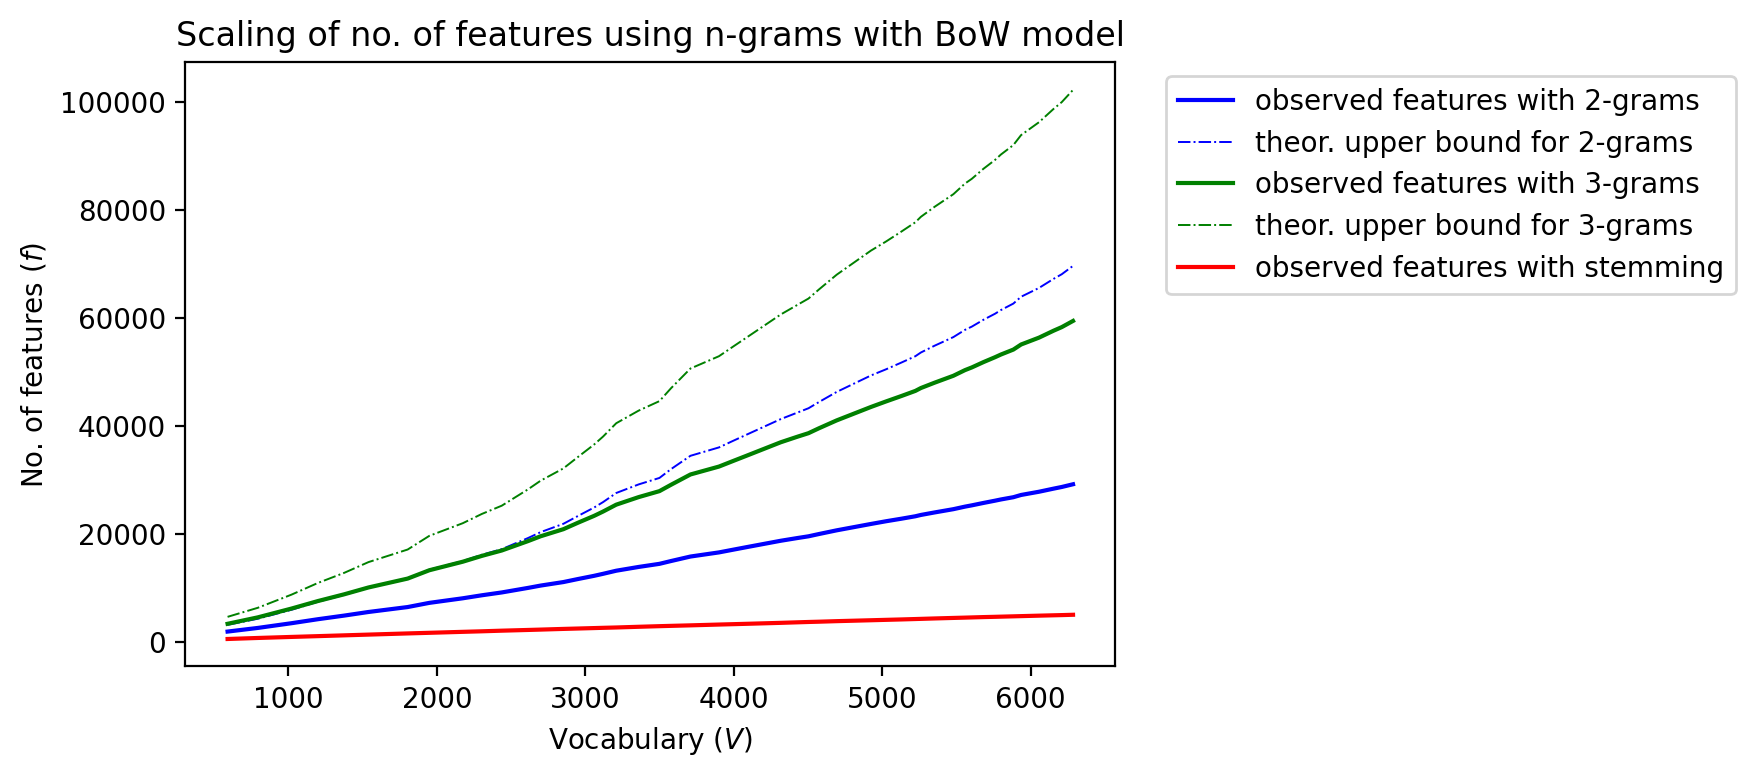

In [ ]:
fig, ax = plt.subplots(dpi=200)

theor1 = (np.array(k1)+np.array(k2))*np.array(V_list)
theor2 = (np.array(k1)+np.array(k2)+np.array(k3))*np.array(V_list) 

ax.plot(V_list, f1, color='b',label='observed features with {}-grams'.format(BOW_ngrams1.Ng))
ax.plot(V_list, theor1, 'b-.', lw=0.7, label='theor. upper bound for {}-grams'.format(BOW_ngrams1.Ng))
ax.plot(V_list,f2,color='g',label='observed features with {}-grams'.format(BOW_ngrams2.Ng))
ax.plot(V_list,theor2,'g-.',lw=0.7, label='theor. upper bound for {}-grams'.format(BOW_ngrams2.Ng))
ax.plot(V_list,f_stemmed,color='r',label='observed features with stemming')
ax.set_title('Scaling of no. of features using n-grams with BoW model')
ax.set_ylabel('No. of features $(f)$')
ax.set_xlabel('Vocabulary $(V)$')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [ ]:
# YOUR CODE HERE
'''Now we report the exact number of features for the entire train corpus
'''
BOW_ngrams1 = BAG_OF_WORDS(use_ngrams=True)
BOW_ngrams2 = BAG_OF_WORDS(use_ngrams=True)
bow1, V1 = BOW_ngrams1.create_bow(train_corpus)
bow2, V2 = BOW_ngrams2.create_bow(train_corpus)
print('No. of features using upto {}-grams as features: {}'.format(BOW_ngrams1.Ng,V1))
print('No. of features using upto {}-grams as features: {}'.format(BOW_ngrams2.Ng,V2))

Enter max number of grams you want to use as features: 2
Enter max number of grams you want to use as features: 3
No. of features using upto 2-grams as features: 465262
No. of features using upto 3-grams as features: 1346107


# Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [ ]:
# YOUR CODE HERE

'''
We define the SVM classifier which inherits the BAG_OF_WORDS class to use them as the features.
See the init method to know the parameters for the classifier.
The classify method returns accuracy and classification report of the SVM classifier. If one wants to 
just use the accuracy, unpack the returned values and use the 1st value.

NOTE: 
    1. We also use the cross-validate method from Naive_Bayes class.
'''
class SVM(BAG_OF_WORDS):
    
    def __init__(self, train, test, use_pos=False, discard_cc=False):
        self.train = train
        self.test = test
        self.use_pos = use_pos
        self.SVM_flag = True
        self.discard_cc = discard_cc
    
    def classify(self):
        train_features, train_labels = self.create_bow(self.train, use_pos = self.use_pos, discard_cc=self.discard_cc)
        test_features, test_labels = self.create_bow(self.test, is_train=False, use_pos=self.use_pos, discard_cc=self.discard_cc)
        model = sk.svm.LinearSVC(max_iter=20000)
        model.fit(train_features, train_labels)
        predicted_labels = model.predict(test_features)
        accuracy = sum(predicted_labels==test_labels)/len(predicted_labels)
        report = sk.metrics.classification_report(test_labels,predicted_labels)
        
        return accuracy, report

In [ ]:
N=10
accuracy_SVM, var_SVM = Naive_Bayes.cross_validate(document=reviews, n_folds=N, use_svm=True)
print('\n Mean accuracy using SVM classifier: {:.3f} with a variance of: {:.4f}'.format(accuracy_SVM,var_SVM))

CV[1/10]: Accuracy: 0.81, Time: 13.59
CV[2/10]: Accuracy: 0.795, Time: 18.22
CV[3/10]: Accuracy: 0.8, Time: 13.40
CV[4/10]: Accuracy: 0.84, Time: 15.45
CV[5/10]: Accuracy: 0.85, Time: 17.54
CV[6/10]: Accuracy: 0.815, Time: 16.44
CV[7/10]: Accuracy: 0.845, Time: 16.00
CV[8/10]: Accuracy: 0.85, Time: 15.98
CV[9/10]: Accuracy: 0.875, Time: 18.03
CV[10/10]: Accuracy: 0.84, Time: 13.22

 Mean accuracy using SVM classifier: 0.832 with a variance of: 0.0007


**Answer**  

We dont perform any explicit hyperparameter tuning on the SVM classifier. However, to ensure that the optimization process, on which linear SVM is based, converges we set a large value *(20000)* of the *max_iter* parameter. Comparing our results with Naive Bayes classifier with smoothing, we observe that SVM classifier improves accuracy by about $1.6\%$. SVM achieves good results, though parameter values for each feature do not enclose a semantic interpretation, as input data are projected to a higher dimensional space in order to become linearly separable.   
However, the computational time for SVM classifier is more than $15$ times higher than the Naive Bayes. We believe this is because computations with Naive Bayes are fairly straight-forward and quick once the Bag of Words is created. On the other hand, solving the linear SVM is just like solving a quadratic optimization problem. The solver is typically an iterative algorithm that keeps a running estimate of the solution and stops running when the solution corresponds to an objective value that is optimal for this convex optimization problem.

### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



#### (Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)

In [ ]:
accuracy_pos, var_pos = Naive_Bayes.cross_validate(document=reviews, n_folds=N, use_svm=True, use_pos=True)
print('\n Mean accuracy of SVM including POS tags as features: {:.3f} with a variance of: {:.4f}'.format(accuracy_pos,var_pos))

CV[1/10]: Accuracy: 0.82, Time: 16.75
CV[2/10]: Accuracy: 0.795, Time: 18.69
CV[3/10]: Accuracy: 0.825, Time: 20.69
CV[4/10]: Accuracy: 0.84, Time: 16.75
CV[5/10]: Accuracy: 0.84, Time: 20.29
CV[6/10]: Accuracy: 0.845, Time: 21.45
CV[7/10]: Accuracy: 0.855, Time: 18.91
CV[8/10]: Accuracy: 0.855, Time: 19.31
CV[9/10]: Accuracy: 0.865, Time: 20.21
CV[10/10]: Accuracy: 0.84, Time: 16.02

 Mean accuracy of SVM including POS tags as features: 0.838 with a variance of: 0.0004


**Answer**

Comparing with our results from **Q3.1** we observe that using words + POS tags as features does not help as we don't see significant accuracy gains. This is also what *Pang et al., 2002 [Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704)* observe in their results though they use feature presence as inputs for their classification.

This seems counterintutive at first because there are words whose connotations w.r.t sentiment are different depending on which POS they belong to. For instance, *'love'* as a *Verb* in *'I love the movie'* has a strong positive connotation, compared to the *Noun* form in *'The child wanted some love'* which is neutral and likely to be part of the plot summary. The latter case would have no influnce on the probability of positive sentiment. However in most cases, one of the versions is much more likely to occur. This is because using non-neutral words such as *'love'* in a neutral context is relatively subjective and depends on the lexical preference of a person than using it to convey its most commonly used form, which for *'love'* is positive sentiment. Another way to think about this is - we may only see the occurence of *'love'* as Noun while training but not in the test set, due to the lexical preference of a reviewer to use *'love'* as Noun in the training corpus. On the other hand *'love'* as Verb would be found commonly both in train and test sets due to a general consensus on using *'love'* to convey *'I like something'*. In addition we also observe that adding POS tags increases the feature count which results in computational overheads and the classifier takes more time to execute. 

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [ ]:
N=10
accuracy_dcc, var_dcc = Naive_Bayes.cross_validate(document=reviews, n_folds=N, use_svm=True, use_pos=True, discard_cc=True)
print('\n Mean accuracy of SVM discarding closed-class words: {:.3f} with a variance of: {:.4f}'.format(accuracy_dcc,var_dcc))

CV[1/10]: Accuracy: 0.83, Time: 13.75
CV[2/10]: Accuracy: 0.84, Time: 13.73
CV[3/10]: Accuracy: 0.835, Time: 13.85
CV[4/10]: Accuracy: 0.86, Time: 13.63
CV[5/10]: Accuracy: 0.85, Time: 14.27
CV[6/10]: Accuracy: 0.795, Time: 13.81
CV[7/10]: Accuracy: 0.875, Time: 13.79
CV[8/10]: Accuracy: 0.855, Time: 13.82
CV[9/10]: Accuracy: 0.845, Time: 14.09
CV[10/10]: Accuracy: 0.825, Time: 13.47

 Mean accuracy of SVM discarding closed-class words: 0.841 with a variance of: 0.0005


**Answer**  

Comparing our results with **Q3.2** we observe that accuracy improves by about *$0.3\%$* which is not significant. This result suggests that no semantically meaningful information was lost (or added) by removing closed-class words. In fact all of the important information is captured by just including the open-class words. Intuitively this makes sense, because *closed-class* words *(and, or, the, this, that, etc.)* primarily act as markers or guides to the structure of a sentence. For instance, prepositions mark special relationships between persons, objects, and locations , Conjunctions are connectors that link actors or objects, and specify relationships between clauses in the sentence. In contrast, *open-class* words are termed **'content'** words as they convey most of the meaning of a sentence and there is less ambiguity in the semantics of the words from this class.

We agree that including closed-class words is detrimental to the classifier. This is because including them does not give additional advantage as explained above but instead, increases the dimensionality of our problem due to increase in number of features. This is also evident from our expirments above, where we observed that execution times improved by an avergage of **$24.5\%$** when we discard closed-class words without significant loss in accuracy.

# (Q4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?

*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.  

The Naive Bayes method, using a $\kappa=1$ smoothing factor was used as a baseline for comparison across all the other BoW techniques. Below, we enlist the benefits and limitations of each technique:

- **Lexicon-Based Approach**  
This approach is a form of unsupervised learning and thus simple to implement and fast to execute. Unlike supervised approach, this one doesn't require large datasets to train and can even work for smaller problem instances effectively.
However, lexicons are specific to a given situation, for eg., a health-related sentiment lexicon would be ineffective in classifying movie reviews. Also, the classification is done without taking into account the data itself and adding or updating lexicons would require expert domain knowledge. Such considerations placed a limit to our classification accuracy ($70\%$) even when we include magnitude information and experimented with a range of multipliers.  
    
- **Naive Bayes**  
The classifier is straight forward to implement and very fast- no iterations were involved since the probabilities can be directly computed from the BoW. However, a limitation of the approach is the *Conditional Independence Assumption* which does not always hold in real world. Also if we encounter words in the test data for a particular class that were not present while training, we end up with zero class probabilities. Surprisingly, the NB classifier outperformed all other techniques with optimal accuracy and least computational time. NB can be optimal even if the independence assumption is violated (*Domingos and Pazzani,1997 [[1]](https://link.springer.com/article/10.1023/A:1007413511361), Zhang, H. 2005 [[2]](https://www.worldscientific.com/doi/abs/10.1142/S0218001405003983)*) and the zero probability problem can be tackled using suitable smoothing as discussed above.  
The best features for NB classifier were simply the original words, without stemming and using n-grams. While stemming didn't impact the performance much, using bi- and tri-grams proved sub-optimal. 

    - <ins>*Stemming*</ins>  creates a shorter vocabulary space and reduces feature space, however it may cause ambiguities that will  eventually lead to several false positives. For example the phrase *'loved the movie'* refers to positive sentiment for the movie, while *'lovable character'* may be about one of the actors. In this case stemming makes classification worse.  
    - With <ins>*n-grams*</ins> we tried to capture the context in which words are used together by using word order information. However, this resulted in a combinatorial explosion of features leading to large computational overheads. In addition n-grams are a sparse representation of language. This is because n-gram model is based on the probability of words co-occurring and assigns zero probability to all the words that are not seen during training. The problem becomes amplified if we use smoothing because too much probability mass is moved to all these zero probablities. This is also what we observed in our experiments, with accuracy falling for bi- and tri-gram models.

- **SVM**  
Theoretically, SVM is better at capturing the interactions between the features as it doesn't use the *conditional independence assumption*. However, we found its performance sub-optimal as discussed in *Q3.1*,*Q3.2* and *Q3.3*.  

We analyzed three major sentiment classification techniques and found that **NB with smoothing** performed best and the **lex-based approach** was the worst. As *Pang et al., 2002 [[3]](https://dl.acm.org/citation.cfm?id=1118704)* point out with *thwarted-expectations*, we reiterate that our methods do not encode long-distance relationships in sentences, which is problematic for reviews which set up and then overturn expectations, e.g. starting with *'I hated the screenplay'* and ending with *'nevertheless I liked it.'* 

# Submission 


In [ ]:
# Write your names and student numbers here:
# Kamlesh Sahoo #12821721
# Manolis Rerres #13439022

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 